# All imports

In [1]:
import cv2
import os
import random
from google.colab import drive
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Concatenate, Input, Add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Drive Set up

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
input_dirs = {
    'rotten': '/content/drive/MyDrive/data/rotten',
    'mid': '/content/drive/MyDrive/data/mid',
    'fresh': '/content/drive/MyDrive/data/fresh'
}

In [4]:
output_dirs = {
    'rotten': '/content/drive/MyDrive/data/rotten_frames',
    'mid': '/content/drive/MyDrive/data/mid_frames',
    'fresh': '/content/drive/MyDrive/data/fresh_frames'
}

In [ ]:
for category, out_dir in output_dirs.items():
    os.makedirs(out_dir, exist_ok=True)

# Dataset Preparation

## Frame Extraction

In [ ]:
fresh_frames_dir = '/content/drive/MyDrive/data/fresh_frames'
mid_frames_dir = '/content/drive/MyDrive/data/mid_frames'
rotten_frames_dir = '/content/drive/MyDrive/data/rotten_frames'

fresh_images_count = len([file for file in os.listdir(fresh_frames_dir) if file.endswith('.jpg')])
mid_images_count = len([file for file in os.listdir(mid_frames_dir) if file.endswith('.jpg')])
rotten_images_count = len([file for file in os.listdir(rotten_frames_dir) if file.endswith('.jpg')])

print(f"Number of images in fresh_frames: {fresh_images_count}")
print(f"Number of images in mid_frames: {mid_images_count}")
print(f"Number of images in rotten_frames: {rotten_images_count}")

Number of images in fresh_frames: 110
Number of images in mid_frames: 130
Number of images in rotten_frames: 60


## Data preprocessing

In [5]:
base_path = "/content/drive/MyDrive/data/augmented"

folders = {
    "fresh": "augmented_fresh_frames",
    "mid": "augmented_mid_frames",
    "rotten": "augmented_rotten_frames"
}

for label, folder in folders.items():
    folder_path = os.path.join(base_path, folder)
    count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
    print(f"Number of images in {folder}: {count}")

Number of images in augmented_fresh_frames: 1100
Number of images in augmented_mid_frames: 1300
Number of images in augmented_rotten_frames: 600


In [6]:
rotten_dir = os.path.join(base_path, 'augmented_rotten_frames')
mid_dir = os.path.join(base_path, 'augmented_mid_frames')
fresh_dir = os.path.join(base_path, 'augmented_fresh_frames')

In [7]:
batch_size = 32
img_size = (224, 224)

datagen = ImageDataGenerator(
    validation_split=0.3,
)
#Training data
train_data = datagen.flow_from_directory(
    base_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)
#Validation data
val_data = datagen.flow_from_directory(
    base_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 2100 images belonging to 3 classes.
Found 900 images belonging to 3 classes.


# Models Training

## ResNet101

In [ ]:
#Scaling values using preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input

batch_size = 32
img_size = (224, 224)

datagen_preprocessed = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.3
)

# Load training data using datagen_preprocessed
train_data_resnet = datagen_preprocessed.flow_from_directory(
    base_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Load validation data using datagen_preprocessed
val_data_resnet = datagen_preprocessed.flow_from_directory(
    base_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 2100 images belonging to 3 classes.
Found 900 images belonging to 3 classes.


In [ ]:
from tensorflow.keras.applications import ResNet101
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

#Model Building
model_resnet101 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(3, activation='softmax')
])

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
#Compilation
model_resnet101.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#Summary
model_resnet101.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet101 (Functional)          │ (None, 7, 7, 2048)     │    42,658,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,183,491 (164.73 MB)

 Trainable params: 525,315 (2.00 MB)

 Non-trainable params: 42,658,176 (162.73 MB)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import time

# Callbacks
checkpoint_resnet101 = ModelCheckpoint(
    'resnet101_cpu.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

reduce_lr_resnet101 = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

early_stopping_resnet101 = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Start training
start_resnet101 = time.time()

history_resnet101 = model_resnet101.fit(
    train_data_resnet,
    epochs=50,
    validation_data=val_data_resnet,
    callbacks=[checkpoint_resnet101, reduce_lr_resnet101, early_stopping_resnet101]
)

end_resnet101 = time.time()
runtime_resnet101 = end_resnet101 - start_resnet101

print(f"Training Time for ResNet101 model: {runtime_resnet101:.2f} seconds")

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.7580 - loss: 0.6917 
Epoch 1: val_accuracy improved from -inf to 0.93000, saving model to resnet101_cpu.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 1363s 20s/step - accuracy: 0.7595 - loss: 0.6874 - val_accuracy: 0.9300 - val_loss: 0.1674 - learning_rate: 0.0010
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9363 - loss: 0.1838 
Epoch 2: val_accuracy improved from 0.93000 to 0.94444, saving model to resnet101_cpu.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 1055s 16s/step - accuracy: 0.9363 - loss: 0.1837 - val_accuracy: 0.9444 - val_loss: 0.1340 - learning_rate: 0.0010
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9484 - loss: 0.1538 
Epoch 3: val_accuracy did not improve from 0.94444
66/66 ━━━━━━━━━━━━━━━━━━━━ 1036s 16s/step - accuracy: 0.9483 - loss: 0.1540 - val_accuracy: 0.9322 - val_loss: 0.1471 - learning_rate: 0.0010
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9358 - loss: 0.1401 
Epoch 4: val_accuracy improved from 0.94444 to 0.95222, saving model to resnet101_cpu.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 1030s 16s/step - accuracy: 0.9360 - loss: 0.1399 - val_accuracy: 0.9522 - val_loss: 0.1080 - learning_rate: 0.0010
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9495 - loss: 0.1257 
Epoch 5: val_accuracy did not improve from 0.95222
66/66 ━━━━━━━━━━━━━━━━━━━━ 1027s 16s/step - accuracy: 0.9495 - loss: 0.1256 - val_accuracy: 0.9422 - val_loss: 0.1081 - learning_rate: 0.0010
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9625 - loss: 0.0953 
Epoch 6: val_accuracy improved from 0.95222 to 0.95889, saving model to resnet101_cpu.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 1042s 16s/step - accuracy: 0.9624 - loss: 0.0953 - val_accuracy: 0.9589 - val_loss: 0.0900 - learning_rate: 0.0010
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9531 - loss: 0.1043 
Epoch 7: val_accuracy did not improve from 0.95889
66/66 ━━━━━━━━━━━━━━━━━━━━ 1043s 16s/step - accuracy: 0.9532 - loss: 0.1042 - val_accuracy: 0.9544 - val_loss: 0.0909 - learning_rate: 0.0010
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9635 - loss: 0.0825 
Epoch 8: val_accuracy did not improve from 0.95889
66/66 ━━━━━━━━━━━━━━━━━━━━ 1036s 16s/step - accuracy: 0.9634 - loss: 0.0826 - val_accuracy: 0.9578 - val_loss: 0.0959 - learning_rate: 0.0010
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9627 - loss: 0.0829 
Epoch 9: val_accuracy did not improve from 0.95889

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
66/66 ━━━━━━━━━━━━━━━━━━━━ 1034s 16s/step - accuracy: 0.9627 - loss: 0.0829 - val_accura

66/66 ━━━━━━━━━━━━━━━━━━━━ 1034s 16s/step - accuracy: 0.9701 - loss: 0.0664 - val_accuracy: 0.9611 - val_loss: 0.0831 - learning_rate: 2.0000e-04
Epoch 11/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9734 - loss: 0.0591 
Epoch 11: val_accuracy did not improve from 0.96111
66/66 ━━━━━━━━━━━━━━━━━━━━ 1020s 16s/step - accuracy: 0.9735 - loss: 0.0590 - val_accuracy: 0.9589 - val_loss: 0.0810 - learning_rate: 2.0000e-04
Epoch 12/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9808 - loss: 0.0494 
Epoch 12: val_accuracy did not improve from 0.96111
66/66 ━━━━━━━━━━━━━━━━━━━━ 1024s 16s/step - accuracy: 0.9808 - loss: 0.0494 - val_accuracy: 0.9578 - val_loss: 0.0844 - learning_rate: 2.0000e-04
Epoch 13/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9755 - loss: 0.0541 
Epoch 13: val_accuracy did not improve from 0.96111

Epoch 13: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
66/66 ━━━━━━━━━━━━━━━━━━━━ 1041s 16s/step - accuracy: 0.9755 - loss: 

66/66 ━━━━━━━━━━━━━━━━━━━━ 1021s 16s/step - accuracy: 0.9781 - loss: 0.0523 - val_accuracy: 0.9633 - val_loss: 0.0772 - learning_rate: 4.0000e-05
Epoch 15/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9829 - loss: 0.0426 
Epoch 15: val_accuracy did not improve from 0.96333
66/66 ━━━━━━━━━━━━━━━━━━━━ 1029s 16s/step - accuracy: 0.9829 - loss: 0.0427 - val_accuracy: 0.9622 - val_loss: 0.0768 - learning_rate: 4.0000e-05
Epoch 16/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9874 - loss: 0.0413 
Epoch 16: val_accuracy did not improve from 0.96333
66/66 ━━━━━━━━━━━━━━━━━━━━ 1020s 16s/step - accuracy: 0.9873 - loss: 0.0414 - val_accuracy: 0.9600 - val_loss: 0.0776 - learning_rate: 4.0000e-05
Epoch 17/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9791 - loss: 0.0489 
Epoch 17: val_accuracy did not improve from 0.96333

Epoch 17: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
66/66 ━━━━━━━━━━━━━━━━━━━━ 1025s 16s/step - accuracy: 0.9792 - loss: 0

In [10]:
model_resnet101 = load_model("resnet101_cpu.h5")

In [11]:
loss_resnet101, accuracy_resnet101 = model_resnet101.evaluate(val_data_resnet)
print(f"Validation Accuracy: {accuracy_resnet101:.4f}, Validation Loss: {loss_resnet101:.4f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 368s 13s/step - accuracy: 0.9595 - loss: 0.0783
Validation Accuracy: 0.9633, Validation Loss: 0.0772


In [13]:
#Prediction on validation data
val_pred_resnet101 = model_resnet101.predict(val_data_resnet)
y_pred_resnet101 = np.argmax(val_pred_resnet101, axis=1)

y_true_resnet101 = val_data_resnet.classes

class_names = list(val_data_resnet.class_indices.keys())

29/29 ━━━━━━━━━━━━━━━━━━━━ 19s 470ms/step


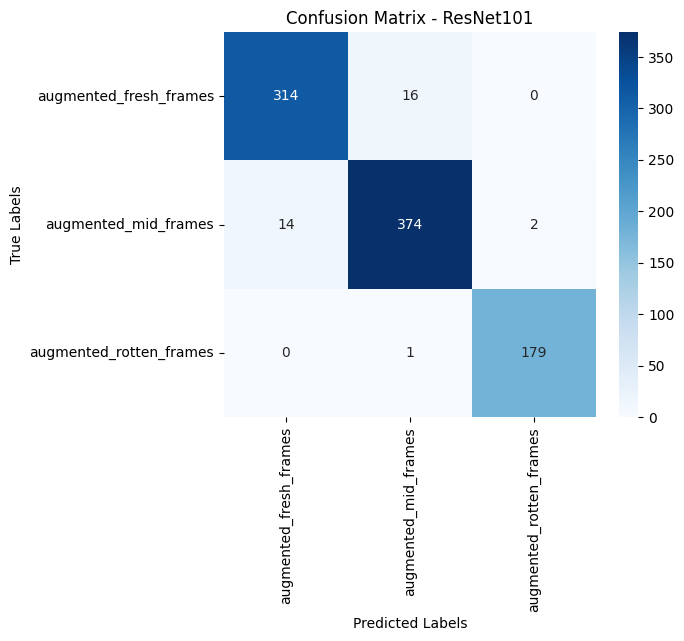

In [14]:
#Confusion matrix
cm_resnet101 = confusion_matrix(y_true_resnet101, y_pred_resnet101)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_resnet101, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - ResNet101")
plt.show()